#  **BUILD DECISION TREE FOR BREAST CANCER DATASET ON SKLEARN**
---

Import necessary library

In [39]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split  
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz


import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

%matplotlib inline

## 1. LOAD DATASET

In [40]:
breast_cancer = load_breast_cancer()
X = breast_cancer.data 
y = breast_cancer.target 
feature_names = breast_cancer.feature_names

df = pd.DataFrame(X, columns=feature_names)
df['Label'] = y
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,Label
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


## 2. SPLIT DATA INTO TRAIN/TEST SETS

In [41]:
ratios = [0.4, 0.6, 0.8, 0.9] # train ratio
datasets = {}

class_distributions = {'original': y}

In [42]:
def split_train_test(X, y, ratio, stratify=True):
    if stratify:
        stratify_param = y
    else:
        stratify_param = None

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=1 - ratio, random_state=42, stratify=stratify_param
    )

    return X_train, X_test, y_train, y_test

In [43]:
for ratio in ratios:
    X_train, X_test, y_train, y_test = split_train_test(X, y, ratio)
    datasets[f'{int(ratio*100)}_train'] = (X_train, y_train)
    datasets[f'{100 - int(ratio*100)}_test'] = (X_test, y_test)
    class_distributions[f'{int(ratio*100)}_train'] = y_train
    class_distributions[f'{100 - int(ratio*100)}_test'] = y_test

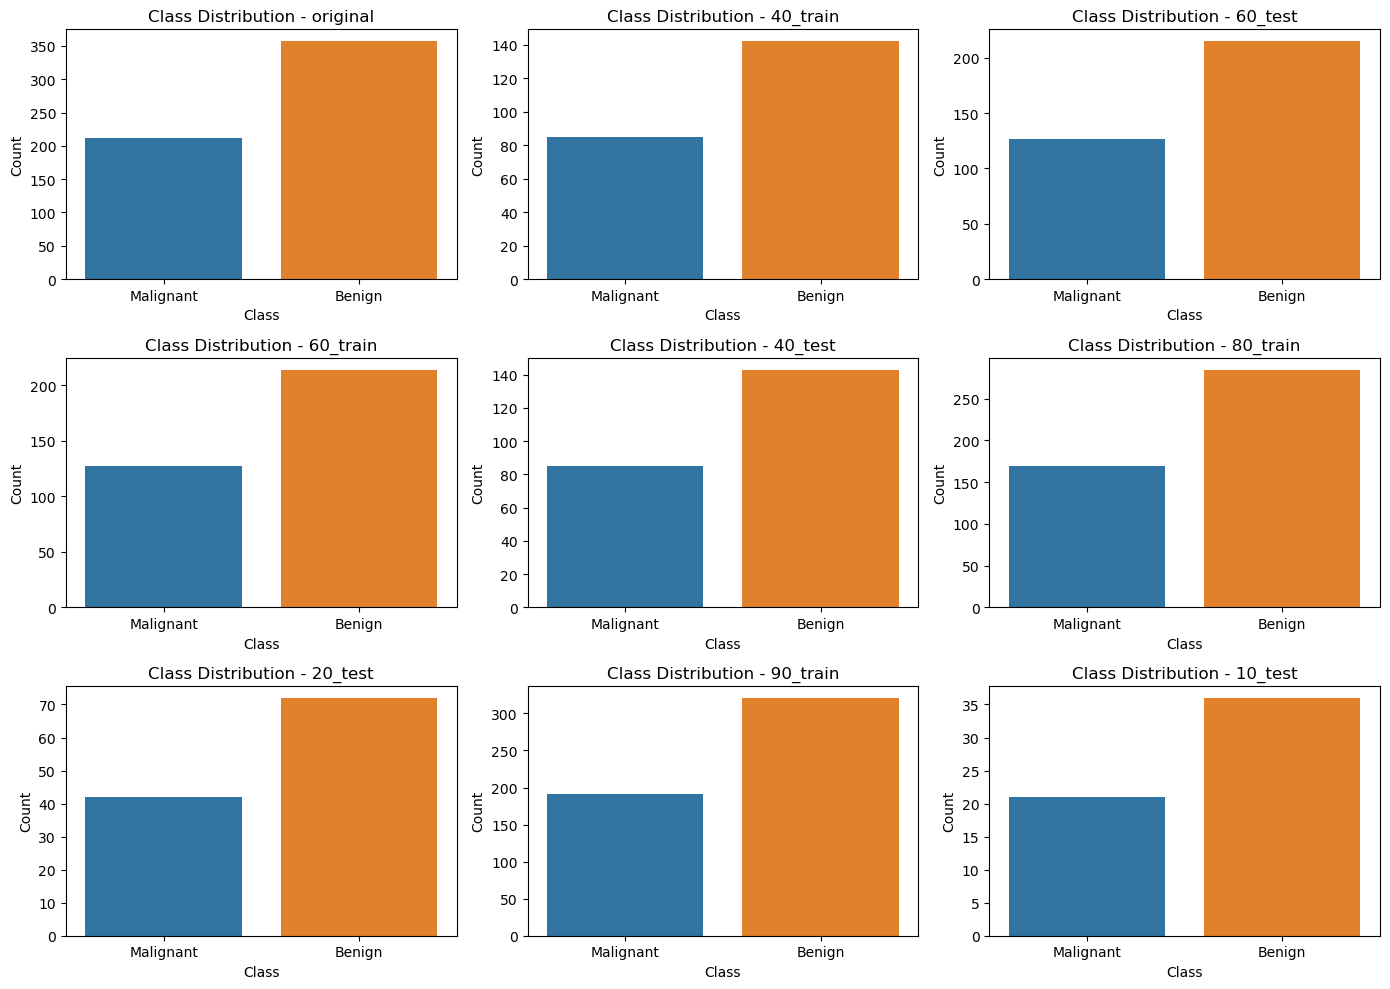

In [44]:
plt.figure(figsize=(14, 10))
for i, (key, y_values) in enumerate(class_distributions.items()):
    plt.subplot(3, 3, i+1)
    sns.countplot(x=y_values)
    plt.title(f'Class Distribution - {key}')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(ticks=[0, 1], labels=['Malignant', 'Benign'])

plt.tight_layout();

- ...

## 3. BUILD DECISION TREE

In [45]:
class DecisionTreeNode:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None, samples=None, entropy=None):
        self.feature = feature          # Chỉ số feature được chọn để chia node
        self.threshold = threshold      # Ngưỡng chia
        self.left = left                # Nhánh con trái
        self.right = right              # Nhánh con phải
        self.value = value              # Giá trị [số mẫu class_0, số mẫu class_1]
        self.samples = samples          # Tổng số mẫu trong node
        self.entropy = entropy          # Entropy của node

In [46]:
class DecisionTree:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.root = None

    def fit(self, X, y):
        self.root = self._build_tree(X, y, depth=0)

    def cal_entropy(self, y):
        _, uniqueClassCounts = np.unique(y, return_counts=True)
        probabilities = uniqueClassCounts / uniqueClassCounts.sum()
        return -np.sum(probabilities * np.log2(probabilities))

    def _build_tree(self, X, y, depth):
        samples = len(y)
        entropy = self.cal_entropy(y)
        value = [np.sum(y == i) for i in np.unique(y)]

        # Điều kiện dừng
        if len(np.unique(y)) == 1:
            return DecisionTreeNode(value=value, samples=samples, entropy=entropy)
        
        if self.max_depth is not None and depth >= self.max_depth:
            return DecisionTreeNode(value=value, samples=samples, entropy=entropy)

        # Tìm feature và threshold tốt nhất
        feature, threshold = self._best_split(X, y)

        # Tách dữ liệu
        left_idx = X[:, feature] <= threshold
        right_idx = ~left_idx
        left = self._build_tree(X[left_idx], y[left_idx], depth + 1)
        right = self._build_tree(X[right_idx], y[right_idx], depth + 1)

        return DecisionTreeNode(feature=feature, threshold=threshold, left=left, right=right,
                                samples=samples, entropy=entropy, value=value)

    def _best_split(self, X, y):
        # Tìm feature và ngưỡng chia tốt nhất (có thể dùng giảm entropy)
        best_feature, best_threshold = None, None
        best_gain = -1

        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                left_idx = X[:, feature] <= threshold
                right_idx = ~left_idx
                if len(y[left_idx]) == 0 or len(y[right_idx]) == 0:
                    continue
                gain = self._information_gain(y, y[left_idx], y[right_idx])
                if gain > best_gain:
                    best_gain, best_feature, best_threshold = gain, feature, threshold
        return best_feature, best_threshold

    def _information_gain(self, y, y_left, y_right):
        # Tính entropy trước khi phân chia
        entropy_before = self.cal_entropy(y)

        # Tính entropy sau khi phân chia
        weight_left = len(y_left) / len(y)
        weight_right = len(y_right) / len(y)
        entropy_after = weight_left * self.cal_entropy(y_left) + weight_right * self.cal_entropy(y_right)
        return entropy_before - entropy_after
    
    def predict(self, X):
        return np.array([self._predict_single(x, self.root) for x in X])

    def _predict_single(self, x, node):
        # Nếu là node lá
        if node.value is not None:
            return np.argmax(node.value)  # Trả về lớp có nhiều mẫu nhất

        # Điều hướng qua cây dựa trên feature và threshold
        if x[node.feature] <= node.threshold:
            return self._predict_single(x, node.left)
        else:
            return self._predict_single(x, node.right)

In [47]:
home_tree = DecisionTree(max_depth=3)
home_tree.fit(X, y)

y_prediction = home_tree.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_prediction))

Accuracy: 0.631578947368421
